In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sys
from tqdm import tqdm
import tensorflow as tf
import edward as ed
from edward.models import Normal, Categorical
from subprocess import check_output
import matplotlib.pyplot as plt

ed.set_seed(12)
%matplotlib inline

In [2]:
data = pd.read_csv('mushrooms.csv')

In [3]:
data2 = pd.get_dummies(data)
data2.shape

(8124, 119)

In [36]:
data_x = data2.loc[:, 'cap-shape_b':].as_matrix().astype(np.float32)
data_y = data2.loc[:, :'class_p'].as_matrix().astype(np.float32)

N = 7000
train_x, test_x = data_x[:N], data_x[N:]
train_y, test_y = data_y[:N], data_y[N:]

in_size = train_x.shape[1]
out_size = train_y.shape[1]


# for bayesian neural network
train_y2 = np.argmax(train_y, axis=1)
test_y2 = np.argmax(test_y, axis=1)

In [37]:
EPOCH_NUM = 20
BATCH_SIZE = 1000

In [38]:
#build a bnn
x_ = tf.placeholder(tf.float32, shape=(None, in_size))
y_ = tf.placeholder(tf.int32, shape=(BATCH_SIZE))

In [39]:
#two-layer neural network.
def neural_network(x, W_0, W_1, b_0, b_1):
    h = tf.matmul(x, W_0) + b_0
    h = tf.tanh(h)
    #h = tf.exp(tf.negative(tf.square(h)))
    h = tf.matmul(h, W_1) + b_1
    return h

def display_draws(loss, train_x, EPOCH_NUM):
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16, 3.5))
    plt.plot(np.arange(EPOCH_NUM), train_loss / len(train_x), label='Train')
    plt.legend(fontsize=20)
    plt.xlabel('Epoch', fontsize=15)
    plt.ylabel('KL', fontsize=15)
    plt.show()

# Compare Mini Batch Size (SGD of KLqp)

In [40]:
EPOCH_NUM = 40
#batch sizes
small_batch = N/10
mid_batch = N/7
big_batch = N/5
#initialize losses
train_losssb = np.zeros(EPOCH_NUM)
train_lossmb = np.zeros(EPOCH_NUM)
train_lossbb = np.zeros(EPOCH_NUM)

with sess:
    batch_x = train_x[0:BATCH_SIZE]
    batch_y = train_y2[0:BATCH_SIZE]
    info_dict = inference.update(feed_dict={x_: batch_x, y_: batch_y})
    train_losssb[0] = info_dict['loss']
    train_lossmb[0] = info_dict['loss']
    train_lossbb[0] = info_dict['loss']

In [ ]:
BATCH_SIZE = small_batch
#build a bnn
x_ = tf.placeholder(tf.float32, shape=(None, in_size))
y_ = tf.placeholder(tf.int32, shape=(BATCH_SIZE))
w0 = Normal(loc=tf.zeros([in_size, out_size]), scale=tf.ones([in_size, out_size]))
b0 = Normal(loc=tf.zeros([out_size]), scale=tf.ones([out_size]))
w1 = Normal(loc=tf.zeros([out_size, in_size]), scale=tf.ones([out_size, in_size]))
b1 = Normal(loc=tf.zeros([in_size]), scale=tf.ones([in_size]))
y_pre =Categorical(neural_network(x_, w0,w1, b0, b1))
qw0 = Normal(loc=tf.Variable(tf.random_normal([in_size, out_size])), scale=tf.Variable(tf.random_normal([in_size, out_size])))
qb0 = Normal(loc=tf.Variable(tf.random_normal([out_size])), scale=tf.Variable(tf.random_normal([out_size])))
qw1 = Normal(loc=tf.Variable(tf.random_normal([out_size, in_size])), scale=tf.Variable(tf.random_normal([out_size, in_size])))
qb1 = Normal(loc=tf.Variable(tf.random_normal([in_size])), scale=tf.Variable(tf.random_normal([in_size])))
y =Categorical(neural_network(x_, qw0,qw1, qb0, qb1))

inference = ed.KLqp({w0: qw0, b0: qb0,w1:qw1,b1:qb1}, data={y_pre: y_})
inference.initialize()
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [ ]:
with sess:
    samples_num = 100
    for epoch in tqdm(range(EPOCH_NUM), file=sys.stdout):
        perm = np.random.permutation(N)
        for i in range(0, N, BATCH_SIZE):
            batch_x = train_x[perm[i:i+BATCH_SIZE]]
            batch_y = train_y2[perm[i:i+BATCH_SIZE]]
            info_dict = inference.update(feed_dict={x_: batch_x, y_: batch_y})
        train_losssb[epoch] = info_dict['loss']
        y_samples = y.sample(samples_num).eval(feed_dict={x_: train_x})
        acc = (np.round(y_samples.sum(axis=0) / samples_num) == train_y2).mean()
        y_samples = y.sample(samples_num).eval(feed_dict={x_: test_x})
        test_acc = (np.round(y_samples.sum(axis=0) / samples_num) == test_y2).mean()
        if (epoch+1) % 10 == 0:
            tqdm.write('epoch:\t{}\taccuracy:\t{}\tvaridation accuracy:\t{}'.format(epoch+1, acc, test_acc))
sess.close()

epoch:	10	accuracy:	0.106714285714	varidation accuracy:	0.114768683274
 45%|████▌     | 18/40 [00:31<00:38,  1.76s/it]

In [ ]:
BATCH_SIZE = mid_batch
#build a bnn
x_ = tf.placeholder(tf.float32, shape=(None, in_size))
y_ = tf.placeholder(tf.int32, shape=(BATCH_SIZE))
w0 = Normal(loc=tf.zeros([in_size, out_size]), scale=tf.ones([in_size, out_size]))
b0 = Normal(loc=tf.zeros([out_size]), scale=tf.ones([out_size]))
w1 = Normal(loc=tf.zeros([out_size, in_size]), scale=tf.ones([out_size, in_size]))
b1 = Normal(loc=tf.zeros([in_size]), scale=tf.ones([in_size]))
y_pre =Categorical(neural_network(x_, w0,w1, b0, b1))
qw0 = Normal(loc=tf.Variable(tf.random_normal([in_size, out_size])), scale=tf.Variable(tf.random_normal([in_size, out_size])))
qb0 = Normal(loc=tf.Variable(tf.random_normal([out_size])), scale=tf.Variable(tf.random_normal([out_size])))
qw1 = Normal(loc=tf.Variable(tf.random_normal([out_size, in_size])), scale=tf.Variable(tf.random_normal([out_size, in_size])))
qb1 = Normal(loc=tf.Variable(tf.random_normal([in_size])), scale=tf.Variable(tf.random_normal([in_size])))
y =Categorical(neural_network(x_, qw0,qw1, qb0, qb1))

inference = ed.KLqp({w0: qw0, b0: qb0,w1:qw1,b1:qb1}, data={y_pre: y_})
inference.initialize()
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [ ]:
with sess:
    samples_num = 100
    for epoch in tqdm(range(EPOCH_NUM), file=sys.stdout):
        perm = np.random.permutation(N)
        for i in range(0, N, BATCH_SIZE):
            batch_x = train_x[perm[i:i+BATCH_SIZE]]
            batch_y = train_y2[perm[i:i+BATCH_SIZE]]
            info_dict = inference.update(feed_dict={x_: batch_x, y_: batch_y})
        train_lossmb[epoch] = info_dict['loss']
        y_samples = y.sample(samples_num).eval(feed_dict={x_: train_x})
        acc = (np.round(y_samples.sum(axis=0) / samples_num) == train_y2).mean()
        y_samples = y.sample(samples_num).eval(feed_dict={x_: test_x})
        test_acc = (np.round(y_samples.sum(axis=0) / samples_num) == test_y2).mean()
        if (epoch+1) % 10 == 0:
            tqdm.write('epoch:\t{}\taccuracy:\t{}\tvaridation accuracy:\t{}'.format(epoch+1, acc, test_acc))
sess.close()

In [ ]:
BATCH_SIZE = big_batch
#build a bnn
x_ = tf.placeholder(tf.float32, shape=(None, in_size))
y_ = tf.placeholder(tf.int32, shape=(BATCH_SIZE))
w0 = Normal(loc=tf.zeros([in_size, out_size]), scale=tf.ones([in_size, out_size]))
b0 = Normal(loc=tf.zeros([out_size]), scale=tf.ones([out_size]))
w1 = Normal(loc=tf.zeros([out_size, in_size]), scale=tf.ones([out_size, in_size]))
b1 = Normal(loc=tf.zeros([in_size]), scale=tf.ones([in_size]))
y_pre =Categorical(neural_network(x_, w0,w1, b0, b1))
qw0 = Normal(loc=tf.Variable(tf.random_normal([in_size, out_size])), scale=tf.Variable(tf.random_normal([in_size, out_size])))
qb0 = Normal(loc=tf.Variable(tf.random_normal([out_size])), scale=tf.Variable(tf.random_normal([out_size])))
qw1 = Normal(loc=tf.Variable(tf.random_normal([out_size, in_size])), scale=tf.Variable(tf.random_normal([out_size, in_size])))
qb1 = Normal(loc=tf.Variable(tf.random_normal([in_size])), scale=tf.Variable(tf.random_normal([in_size])))
y =Categorical(neural_network(x_, qw0,qw1, qb0, qb1))

inference = ed.KLqp({w0: qw0, b0: qb0,w1:qw1,b1:qb1}, data={y_pre: y_})
inference.initialize()
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [ ]:
with sess:
    samples_num = 100
    for epoch in tqdm(range(EPOCH_NUM), file=sys.stdout):
        perm = np.random.permutation(N)
        for i in range(0, N, BATCH_SIZE):
            batch_x = train_x[perm[i:i+BATCH_SIZE]]
            batch_y = train_y2[perm[i:i+BATCH_SIZE]]
            info_dict = inference.update(feed_dict={x_: batch_x, y_: batch_y})
        train_lossbb[epoch] = info_dict['loss']
        y_samples = y.sample(samples_num).eval(feed_dict={x_: train_x})
        acc = (np.round(y_samples.sum(axis=0) / samples_num) == train_y2).mean()
        y_samples = y.sample(samples_num).eval(feed_dict={x_: test_x})
        test_acc = (np.round(y_samples.sum(axis=0) / samples_num) == test_y2).mean()
        if (epoch+1) % 10 == 0:
            tqdm.write('epoch:\t{}\taccuracy:\t{}\tvaridation accuracy:\t{}'.format(epoch+1, acc, test_acc))
sess.close()

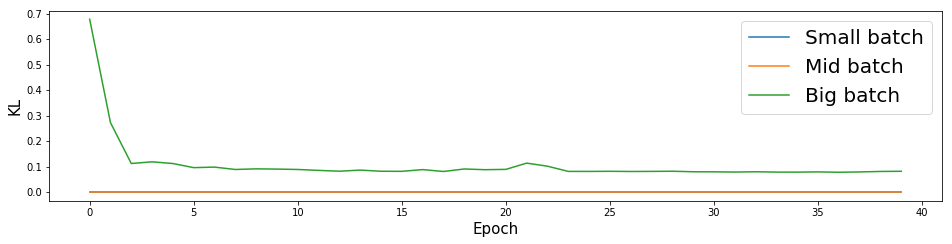

In [31]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16, 3.5))
plt.plot(np.arange(EPOCH_NUM), train_losssb / len(train_x), label='Small batch')
plt.plot(np.arange(EPOCH_NUM), train_lossmb / len(train_x), label='Mid batch')
plt.plot(np.arange(EPOCH_NUM), train_lossbb / len(train_x), label='Big batch')
plt.legend(fontsize=20)
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('KL', fontsize=15)
plt.show()